# Eniac

## 1.Importing Data

Turning them into a dictionary of dataframes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates

orders_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orders_clean.parquet"
orderlines_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/orderlines_clean.parquet"
products_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/products_clean.parquet"
brands_url = "https://raw.githubusercontent.com/MerleSt/Eniac/main/Data-Eniac/Data_Cleaned/brands_clean.parquet"

# Loading dataframes directly from GitHub
orders_df = pd.read_parquet(orders_url)
orderlines_df = pd.read_parquet(orderlines_url)
products_df = pd.read_parquet(products_url)
brands_df = pd.read_parquet(brands_url)

orders = orders_df.copy()
orderlines = orderlines_df.copy()
products = products_df.copy()
brands = brands_df.copy()

Set Display Formats of Pandas

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', 200)

## 2. Data Integration

### 2.1 Mergers and logical combinations

In [3]:
# Rename column to match with orders (better readability)
orderlines.rename(columns={'id_order': 'order_id'}, inplace=True)
orderlines['short'] = orderlines['sku'].str[:3]

In [4]:
oo = orders.merge(orderlines, on='order_id', how='left')
boo = oo.merge(brands, on='short', how='right')

Delete oders where there is one or more products, which are not identified. 
1.make a list of all known products (products table). Go into the orders, orderlines, brands table and exclude orders whose id is not in that list. Lastly merge the products table onto the boo table.

In [5]:
known_products = products['sku']
orders_with_unknown_products = boo.loc[~boo.sku.isin(known_products), "order_id"]
boo = boo.loc[~boo["order_id"].isin(orders_with_unknown_products), :]
df = boo.merge(products, on ='sku', how='left')

### 2.2 Create new columns

#### 2.2.1 Boolean Promotion and Promo_price

Create a boolean condition which is true when a promotion was applied on the price.

In [6]:
df['price_promotion'] = df['unit_price'] < df['price']
df['promo_price'] = df.apply(lambda row: row['unit_price'] if row['price_promotion'] else np.nan, axis=1)
df[['promo_price','price_promotion', 'price']].head()

,promo_price,price_promotion,price
0,23.99,True,35.00
1,23.99,True,35.00
2,23.99,True,35.00
3,23.99,True,35.00
4,23.99,True,35.00


#### 2.2.2 order_price

Use this price to compare to the total paid, to infer knowledge about shipping costs etc.

In [7]:
df['unit_price_total'] = df['product_quantity'] * df['unit_price']
order_total_price = df.groupby('order_id')['unit_price_total'].sum().reset_index()
order_total_price.rename(columns={'unit_price_total': 'order_price'}, inplace=True)
df = df.merge(order_total_price, on='order_id')

#### 2.2.3 Orders with at least one promotional item

In [8]:
df['order_inc_promo'] = df.groupby('order_id')['price_promotion'].transform('any')
df['order_inc_promo'].value_counts()

True     262211
False     15415
Name: order_inc_promo, dtype: int64

#### 2.2.4 Difference between total_paid and order_price

Look at the difference between what was paid and what the products inside the order combined cost. Do this only for completed orders. This might give us insight about promotions on the entire order (10% on your entire oder) or shipping costs. We can also exclude outliers from this, since there might be some corrupted data.

In [9]:
df['diff_paid_totalprice'] = np.where(df['state'] == 'Completed', 
                                     df['total_paid'] - df['order_price'], 
                                     np.nan)

#### 2.2.5 Promotion Percentage per Product

In [10]:
df['promo_perc'] = (1-(df['unit_price']/df['price']))

#### 2.2.6 More date types to access

In [11]:
df[['year', 'week', 'day']]= df['created_date'].dt.isocalendar()
# Extract month and quarter
df['month'] = df['created_date'].dt.month
df['quarter'] = df['created_date'].dt.quarter

### 2.3 Outliers

When checking the unit_price, price and total_paid there might be statistically some outliers, but some products are extremely expensive and therefore, should still be utilised. Howeever, there can be some outliers in the difference between what was paid and the value of that order. These should be excluded, since they can show corrupted data. Let's do this here.

#### 2.3.1 Unit_price 

Let me check the unit_price, the total_paid and the order_price and remove outliers. In the step below I deleted negative prices. Here I want to confine our dataframe into prices that are normal/ usable for promotions. 

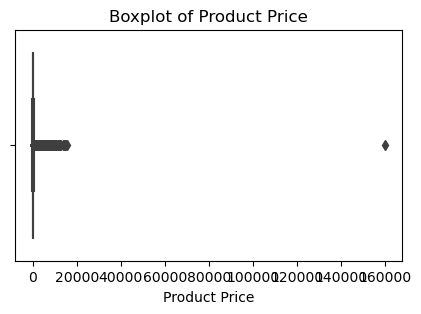

In [12]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['unit_price'])
plt.title('Boxplot of Product Price')
plt.xlabel('Product Price')
plt.show()

In [13]:
Q1 = df['unit_price'].quantile(0.25)
Q3 = df['unit_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['unit_price'] < lower_bound) | (df['unit_price'] > upper_bound)]
print(outliers['unit_price'].count())
proportion_outliers = outliers['unit_price'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('unit_price', ascending=True).head()

41074
0.14794723837104595


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter
46694,417089,2017-10-24 22:56:13,793.66,Shopping Basket,1.00,APP2480,793.66,2017-10-24 22:56:13,APP,Apple,Apple iPhone 8 256GB Space Gray,256GB Apple iPhone 8 Color Space Gray,979.00,False,113291716,True,793.66,793.66,793.66,True,NaN,0.19,2017,43,2,10,4
47123,417781,2017-10-25 21:19:00,793.66,Shopping Basket,1.00,APP2481,793.66,2017-10-25 21:19:00,APP,Apple,Apple iPhone 8 256GB Silver,256GB Apple iPhone 8 in Silver,979.00,False,113291716,True,793.66,793.66,793.66,True,NaN,0.19,2017,43,3,10,4
221192,347202,2017-04-18 20:44:21,793.99,Shopping Basket,1.00,PAC1866,793.99,2017-04-18 20:44:21,PAC,Pack,Synology DS416play | 8TB (4x2TB) WD Red,8TB NAS capacity (4x2TB) WD Red hard drives fo...,830.99,False,12175397,True,793.99,793.99,793.99,True,NaN,0.04,2017,16,2,4,2
184930,521836,2018-03-05 19:58:49,1201.98,Completed,1.00,LAC0211,794.99,2018-03-05 18:54:19,LAC,LaCie,16TB LaCie 2big Thunderbolt 2,RAID 16TB double disc box designed to work 24x...,989.00,False,11935397,True,794.99,794.99,1194.98,True,7.00,0.20,2018,10,1,3,1
32607,380521,2017-07-21 18:20:39,795.00,Completed,1.00,APP2124,795.00,2017-07-21 18:01:00,APP,Apple,"Apple iPad Pro 10.5 ""WiFi 256GB Silver",New iPad Pro 256GB Wi-Fi,899.00,False,106431714,True,795.00,795.00,795.00,True,0.00,0.12,2017,29,5,7,3


After closer inspection, we decided to exclude Unit_prices above 10000€ for now.

In [14]:
df = df.loc[df['unit_price']<10000].copy()

#### 2.3.2 total_paid

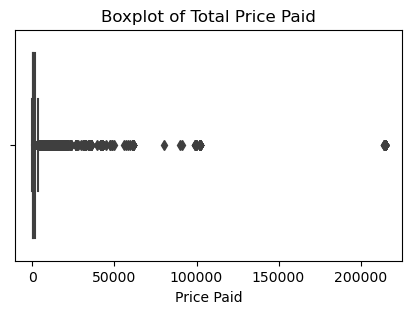

In [15]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['total_paid'])
plt.title('Boxplot of Total Price Paid')
plt.xlabel('Price Paid')
plt.show()

In [16]:
Q1 = df['total_paid'].quantile(0.25)
Q3 = df['total_paid'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['total_paid'] < lower_bound) | (df['total_paid'] > upper_bound)]
print(outliers['total_paid'].count())
proportion_outliers = outliers['total_paid'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('total_paid', ascending=False).head()

26969
0.09715197625326014


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter
8016,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0023,59.00,2017-01-03 20:19:59,APP,Apple,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,False,13855401,False,NaN,59.00,214746.64,True,NaN,0.00,2017,1,2,1,1
8009,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP1629,179.00,2017-01-03 20:18:39,APP,Apple,"Apple iPad Case Smart Keyboard Pro 12.9 """,Cover with keyboard shortcuts and Spanish (dir...,189.00,False,12635403,True,179.00,179.00,214746.64,True,NaN,0.05,2017,1,2,1,1
8011,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0927,19.99,2017-01-03 20:18:56,APP,Apple,EarPods Apple Headphones with Remote and Mic (...,EarPods headphones Apple iPhone iPad and iPod ...,35.00,True,5384,True,19.99,19.99,214746.64,True,NaN,0.43,2017,1,2,1,1
8012,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0698,14.99,2017-01-03 20:18:59,APP,Apple,Apple Lightning Cable Connector to USB 1m Whit...,Apple Lightning USB Cable 1 meter to charge an...,25.00,True,1230,True,14.99,14.99,214746.64,True,NaN,0.40,2017,1,2,1,1
8013,301934,2017-01-03 19:27:13,214746.63,Shopping Basket,1.00,APP0703,72.99,2017-01-03 20:19:04,APP,Apple,"85W MagSafe charger Apple MacBook Pro 15 ""/ 17...",Apple MagSafe Power Charger 85W MacBook Pro un...,89.00,True,13005399,True,72.99,72.99,214746.64,True,NaN,0.18,2017,1,2,1,1


When the unit_price we chose is 5000 euros, then we should include orders above that price, however, we do not need orders of 250 000 Euros. 

In [17]:
df = df.loc[df['total_paid']< 15000].copy()

#### 2.3.3 Difference price paid and the Total price of the order

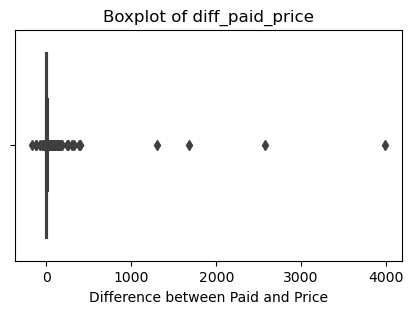

In [18]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['diff_paid_totalprice'])
plt.title('Boxplot of diff_paid_price')
plt.xlabel('Difference between Paid and Price')
plt.show()

In [19]:
Q1 = df['diff_paid_totalprice'].quantile(0.25)
Q3 = df['diff_paid_totalprice'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['diff_paid_totalprice'] < lower_bound) | (df['diff_paid_totalprice'] > upper_bound)]

print(outliers['diff_paid_totalprice'].count())
proportion_outliers = outliers['diff_paid_totalprice'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('diff_paid_totalprice', ascending=False).tail()

1097
0.003961032395973251


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter
142693,319901,2017-02-04 16:09:34,60.43,Completed,1.00,WIT0017-A,71.77,2017-02-04 15:33:46,WIT,Withings,Open - Withings Activite POP Black Clock,Smartwatch that records sleep and movement for...,149.90,False,1298,True,71.77,71.77,142.44,True,-82.01,0.52,2017,5,6,2,1
237892,289685,2017-01-09 23:15:07,15.95,Completed,1.00,STA0052,39.99,2017-01-09 22:01:15,STA,Startech,Startech USB-C 4K HDMI 60Hz White,C USB-HDMI adapter compatible with Thunderbolt...,47.99,True,12585395,True,39.99,39.99,135.97,True,-120.02,0.17,2017,2,1,1,1
237891,289685,2017-01-09 23:15:07,15.95,Completed,1.00,SAN0145,42.99,2017-01-09 00:22:48,SAN,SanDisk,Sandisk Ultra Pen-Drive 128GB USB-C,128GB USB flash drive for Type C devices,53.99,True,11935397,True,42.99,42.99,135.97,True,-120.02,0.20,2017,2,1,1,1
237893,289685,2017-01-09 23:15:07,15.95,Completed,1.00,STA0049,52.99,2017-01-09 23:02:10,STA,Startech,Startech USB-C Adapter USB 3.1 Gigabit Etherne...,USB-C adapter cable (compatible with Thunderbo...,70.99,False,12585395,True,52.99,52.99,135.97,True,-120.02,0.25,2017,2,1,1,1
254339,432303,2017-11-22 21:43:02,261.86,Completed,1.00,SYN0180,426.86,2017-11-22 21:09:22,SYN,Synology,Synology DS718 + NAS server Mac and PC,Scalable NAS server and transcoding 4K: 4-core...,459.99,False,12175397,True,426.86,426.86,426.86,True,-165.00,0.07,2017,47,3,11,4


Let us drop all the remaining outliers here.

In [20]:
df = df.loc[~df['diff_paid_totalprice'].isin(outliers['diff_paid_totalprice'])]

#### 3.2.4 Difference Price and Unit_Price

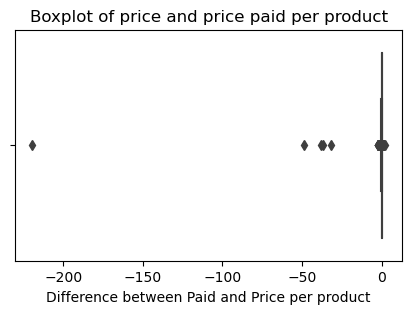

In [21]:
plt.figure(figsize=(5,3))
sns.boxplot(x=df['promo_perc'])
plt.title('Boxplot of price and price paid per product')
plt.xlabel('Difference between Paid and Price per product')
plt.show()

In [22]:
Q1 = df['promo_perc'].quantile(0.25)
Q3 = df['promo_perc'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df['promo_perc'] < lower_bound) | (df['promo_perc'] > upper_bound)]

print(outliers['promo_perc'].count())
proportion_outliers = outliers['promo_perc'].count() / df.shape[0]
print(proportion_outliers)
outliers.sort_values('promo_perc', ascending=False).head()

17942
0.06504235982468796


,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter
26487,365886,2017-06-15 12:51:18,30.00,Cancelled,1.00,APP1465,-119.00,2017-06-15 12:48:54,APP,Apple,Spanish Keyboard Keyboard Magic Apple Mac (OEM),Spanish Keyboard Mac and Apple iPad Ultrathin ...,119.00,True,13855401,True,-119.00,-119.00,30.00,True,NaN,2.00,2017,24,4,6,2
85006,466486,2017-12-19 09:16:28,11.62,Shopping Basket,1.00,APP1809,0.00,2017-12-19 09:16:28,APP,Apple,Apple Apple Pack 4 Pencil Tips,4 extra points for Apple Pencil,25.00,False,1229,True,0.00,0.00,11.61,True,NaN,1.00,2017,51,2,12,4
90230,480296,2018-01-02 21:07:41,0.00,Shopping Basket,1.00,APP2504,0.00,2018-01-02 21:07:41,APP,Apple,Apple Watch GPS 42mm Series 3 Aluminum Case an...,42mm Apple Watch series 3 with GPS altimeter a...,399.00,True,24895185,True,0.00,0.00,0.00,True,NaN,1.00,2018,1,2,1,1
90236,480297,2018-01-02 21:07:50,0.00,Shopping Basket,1.00,XDO0043,0.00,2018-01-02 21:07:50,XDO,X-Doria,X-Doria Defense Edge Apple 42mm Watch Case Bla...,Anti-shock housing for Apple Watch.,29.99,False,2434,True,0.00,0.00,0.00,True,NaN,1.00,2018,1,2,1,1
90235,480297,2018-01-02 21:07:50,0.00,Shopping Basket,1.00,XDO0035,0.00,2018-01-02 21:07:50,XDO,X-Doria,X-Doria Metal Mesh Strap Watch 42mm Black Apple,Mesh belt stainless steel X-Doria for Apple Wa...,49.99,False,2449,True,0.00,0.00,0.00,True,NaN,1.00,2018,1,2,1,1


Let's drop all promo percentages over 90% since it sounds really unreasonable to give that high of percentages.

In [23]:
df = df.loc[df['promo_perc']<0.9].copy()

Only use this code below, when you want to have a copy of the final merged table downloaded.

In [24]:
# from IPython.display import FileLink, FileLinks

# df.to_csv('/Users/merlesteffen/Documents/GitHub/Eniac/Data-Eniac/data.csv', index=False)

Let's see a distributional grpah of the price paid

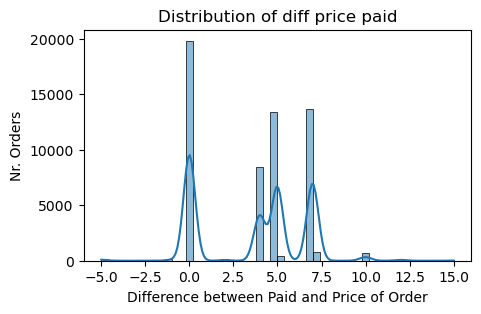

In [25]:
plt.figure(figsize=(5,3))
sns.histplot(df['diff_paid_totalprice'], bins=50, kde=True)
plt.title('Distribution of diff price paid')
plt.xlabel('Difference between Paid and Price of Order')
plt.ylabel('Nr. Orders')
plt.show()

In [26]:
df1 = df.reset_index(drop=True).copy()

#### 2.3.1 Negative prices

In [27]:
# Convert columns to appropriate numeric data type
# Here, I'm assuming columns 'col1', 'col2', ... are the columns you want to check
# You might need to modify this list based on your actual column names.
numeric_cols = ['total_paid', 'product_quantity', 'unit_price', 'price']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Now, find rows with negative values in those columns
negative_rows = df[df[numeric_cols].lt(0).any(axis=1)]
negative_rows

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter


In [28]:
df = df.loc[df['unit_price']>=0].copy()

### 2.4 Second Dataframe, with completed orders

Do this as a laast step so all columns and the cleaning/ merging are the same in both dataframes

In [29]:
df_com = df1.loc[df1['state']=='Completed'].reset_index(drop=True).copy()
df_com.head()

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter
0,347721,2017-04-20 10:22:00,23.99,Completed,1.00,8MO0007,23.99,2017-04-20 10:20:02,8MO,8Mobility,8Mobility iSlice Micro SD adapter for Macbook ...,Micro SD card adapter for MacBook Air 13-inch,35.00,False,12585395,True,23.99,23.99,23.99,True,0.00,0.31,2017,16,4,4,2
1,347743,2017-04-20 11:28:27,23.99,Completed,1.00,8MO0009,23.99,2017-04-20 11:21:25,8MO,8Mobility,8Mobility iSlice Micro SD Adapter for Macbook ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,True,12585395,True,23.99,23.99,23.99,True,0.00,0.31,2017,16,4,4,2
2,347761,2017-04-21 08:56:30,66.97,Completed,1.00,8MO0012,23.99,2017-04-20 11:56:42,8MO,8Mobility,8Mobility iSlice Micro SD Adapter MacBook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,66.97,True,0.00,0.31,2017,16,5,4,2
3,347761,2017-04-21 08:56:30,66.97,Completed,1.00,SAN0140,12.99,2017-04-20 11:56:34,SAN,SanDisk,SanDisk Ultra 32GB microSDHC Memory Card + SD ...,Adapter and microSDHC memory card 32 GB Class ...,12.99,False,57445397,False,NaN,12.99,66.97,True,0.00,0.00,2017,16,5,4,2
4,347761,2017-04-21 08:56:30,66.97,Completed,1.00,SAN0099,29.99,2017-04-21 08:54:44,SAN,SanDisk,SanDisk Connect Wireless Flash Drive 64GB Wire...,Wireless 64GB storage for iPhone / iPad / Mac.,49.99,True,42945397,True,29.99,29.99,66.97,True,0.00,0.40,2017,16,5,4,2


## 3. Analysis

Univariate Analysis

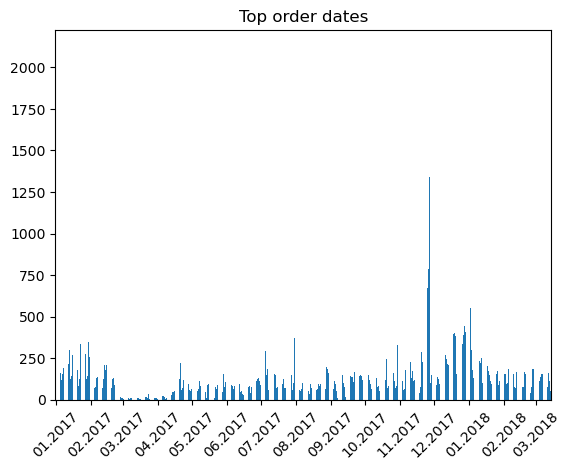

In [30]:
# Plotting the data
ax = df_com['created_date'].dt.date.value_counts().sort_index().plot(kind='bar', title='Top order dates')

# Extract the first date of each unique month-year combination
first_dates_of_each_month = df_com.drop_duplicates(subset='created_date', keep='first').sort_values('created_date')['created_date'].dt.to_period('M').drop_duplicates().dt.to_timestamp()

# Find the positions of these first dates in the sorted index of the dates from df1
positions = [sorted(df1['created_date'].dt.date.unique()).index(date.date()) for date in first_dates_of_each_month]

# Get the month-year labels for these dates
labels = first_dates_of_each_month.dt.strftime('%m.%Y')

# Set the tick positions and labels
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45)
plt.show()

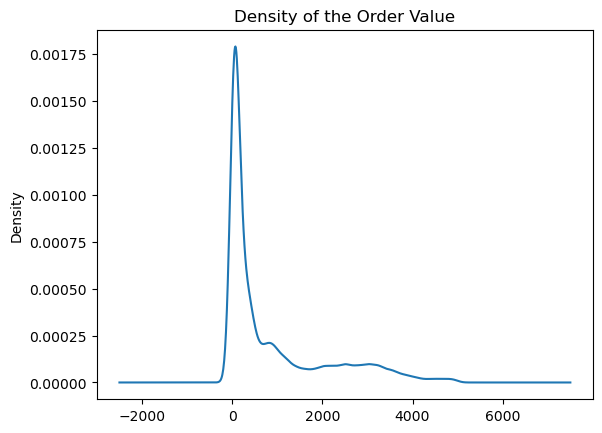

In [31]:
filtered_order_prices = df1[df1['order_price'] < 5000]['order_price']
filtered_order_prices.plot(kind='kde', title='Density of the Order Value');

In [32]:
df1['unit_price'].sort_values()

170022      1.99
168055      1.99
168149      1.99
168312      1.99
168099      1.99
           ...  
124348   9656.00
112707   9663.23
218520   9841.99
218699   9841.99
218666   9841.99
Name: unit_price, Length: 275106, dtype: float64

In [33]:
df1.loc[df1['unit_price']<0]

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter


In [34]:
df1.dtypes

order_id                        object
created_date            datetime64[ns]
total_paid                     float64
state                         category
product_quantity               float64
sku                             object
unit_price                     float64
date                    datetime64[ns]
short                           object
long                            object
name                            object
desc                            object
price                          float64
in_stock                          bool
type                          category
price_promotion                   bool
promo_price                    float64
unit_price_total               float64
order_price                    float64
order_inc_promo                   bool
diff_paid_totalprice           float64
promo_perc                     float64
year                            UInt32
week                            UInt32
day                             UInt32
month                    

### 3.1 Analyzing Order Patterns in Relation to Discounts

Objective:
To understand if the introduction or availability of discounts affects order patterns – both in terms of quantity and frequency.

#### 3.1.1 Understand basic metrics

In [35]:
total_orders = df1['order_id'].nunique()
avg_order_value = df1.groupby('order_id')['total_paid'].first().mean()

avg_items_per_order = df1.groupby('order_id').size().mean()
print(f'The total orders are: {total_orders}, the average order values is: {avg_order_value}, and the average items per order are: {avg_items_per_order}')


The total orders are: 194788, the average order values is: 606.3651910281948, and the average items per order are: 1.4123354621434585


Let me check if all total_paid values are the same within each order

In [36]:
unique_paid_counts = df1.groupby('order_id')['total_paid'].nunique()
inconsistent_orders = unique_paid_counts[unique_paid_counts > 1]
if not inconsistent_orders.empty:
    print("There are orders with inconsistent 'total_paid' values:")
    print(inconsistent_orders)
else:
    print("All orders have consistent 'total_paid' values. Therefore I can use the .first() method.")

All orders have consistent 'total_paid' values. Therefore I can use the .first() method.


#### 3.1.2 Compare Metrics

In [37]:
avg_order_value_discounted =(
    df1[df1['order_inc_promo'] == True]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)
avg_order_value_non_discounted =(
    df1[df1['order_inc_promo'] == False]
    .groupby('order_id')['total_paid']
    .sum()
    .mean()
    .round(2)
)

In [38]:
avg_items_discounted =(
    df1[df1['order_inc_promo'] == True]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)
avg_items_non_discounted =(
    df1[df1['order_inc_promo'] == False]
    .groupby('order_id')['product_quantity']
    .sum()
    .mean()
    .round(2)
)

In [39]:
print(f'The average order value of discounted orders is: {avg_order_value_discounted}, compared to the average value of non discounted orders: {avg_order_value_non_discounted}\
. Moreover, the average number of items in an order with prmotion is: {avg_items_discounted}, while it is : {avg_items_non_discounted} for non discounted orders.')

The average order value of discounted orders is: 1432.66, compared to the average value of non discounted orders: 358.11. Moreover, the average number of items in an order with prmotion is: 1.59, while it is : 1.22 for non discounted orders.


### 3.2 Temporal Analysis

For now only use completed orders, since otherwise we cannot infer about the promotion.

In [40]:
df1['created_month'] = df1['created_date'].dt.month # this is an integer, maybe change later
monthly_discounted_orders = df1[df1['price_promotion']].groupby('created_month').size()
monthly_discounted_orders

created_month
1     52486
2     31457
3     20792
4      9189
5      8936
6      9095
7     13513
8      9773
9     11123
10    13582
11    38981
12    31096
dtype: int64

### 3.3 Visual Analysis

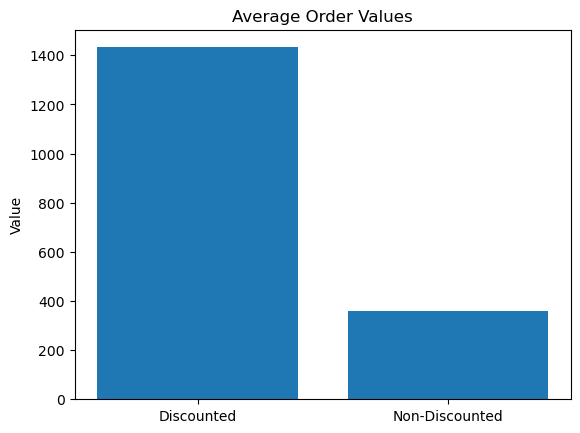

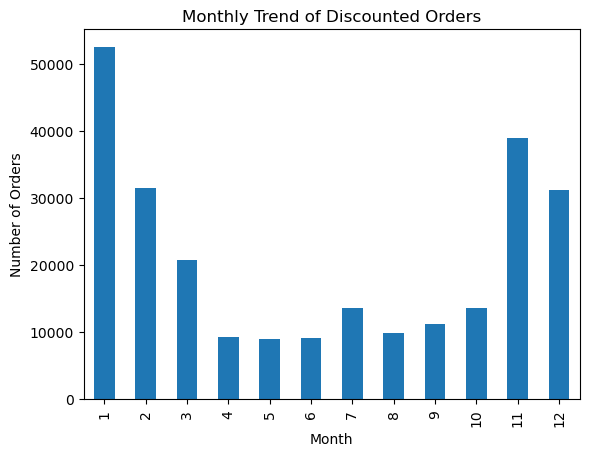

In [41]:
import matplotlib.pyplot as plt

# Average order values comparison
plt.bar(['Discounted', 'Non-Discounted'], [avg_order_value_discounted, avg_order_value_non_discounted])
plt.title('Average Order Values')
plt.ylabel('Value')
plt.show()

# Monthly trends of discounted orders
monthly_discounted_orders.plot(kind='bar')
plt.title('Monthly Trend of Discounted Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Month')
plt.show()


Possible Conclusions:

- If orders with discounts have a significantly higher average value or quantity, it suggests discounts might be driving larger orders.
- If there's a temporal trend showing increased discount orders during specific times, it might suggest seasonal trends or the effects of periodic discount campaigns.

### 3.4 Which Items are bought together

In [42]:
df['grouped'] = df.groupby('order_id')['name'].transform(lambda x: ','.join(x))

In [43]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df['grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))
    
# Print only the first few, since dataframe is too large.
for item, freq in count.most_common(10):
    print(item, freq)

('Apple Magic Trackpad 2', 'Office 365 Personal 1 license 1 M ± or') 21039
('IMac AppleCare Protection Plan', 'Office 365 Personal 1 license 1 M ± or') 17664
('IMac AppleCare Protection Plan', 'Apple Magic Trackpad 2') 14153
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'My MW Case MacBook Pro 13 "(Late 2016) Black') 9462
('My MW Case MacBook Pro 13 "(Late 2016) Black', 'Satechi Hub Multiport USB-C 4K HDMI Space Gray') 4735
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'Satechi Multiport USB Hub HDMI 4K-C Plata') 4732
('My MW Case MacBook Pro 13 "(Late 2016) Black', 'Satechi Multiport USB Hub HDMI 4K-C Plata') 4724
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'Satechi Hub Multiport USB-C 4K HDMI Space Gray') 4722
('Apple Magic Trackpad 2', 'IMac AppleCare Protection Plan') 3538
('AppleCare Protection Plan MacBook / Air / Pro 13 "', 'Office 365 Personal 1 license 1 M ± or') 3170


### 3.5 Analyzing Customer Behavior and Retention with Respect to Discounts:

#### 3.5.1 Retention Rate with Respect to Discounts:

To understand if customers acquired during promotional periods are more likely to come back.

In [44]:
grouped = (
    df1
    .loc[df1['state'] == 'Completed']
    .groupby(['week', 'month', 'quarter', 'year'])
    ['promo_perc']
    .mean()
    .reset_index()
)

grouped

,week,month,quarter,year,promo_perc
0,1,1,1,2017,0.22
1,1,1,1,2018,0.19
2,2,1,1,2017,0.26
3,2,1,1,2018,0.24
4,3,1,1,2017,0.22
...,...,...,...,...,...
71,49,12,4,2017,0.16
72,50,12,4,2017,0.15
73,51,12,4,2017,0.21
74,52,1,1,2016,0.21


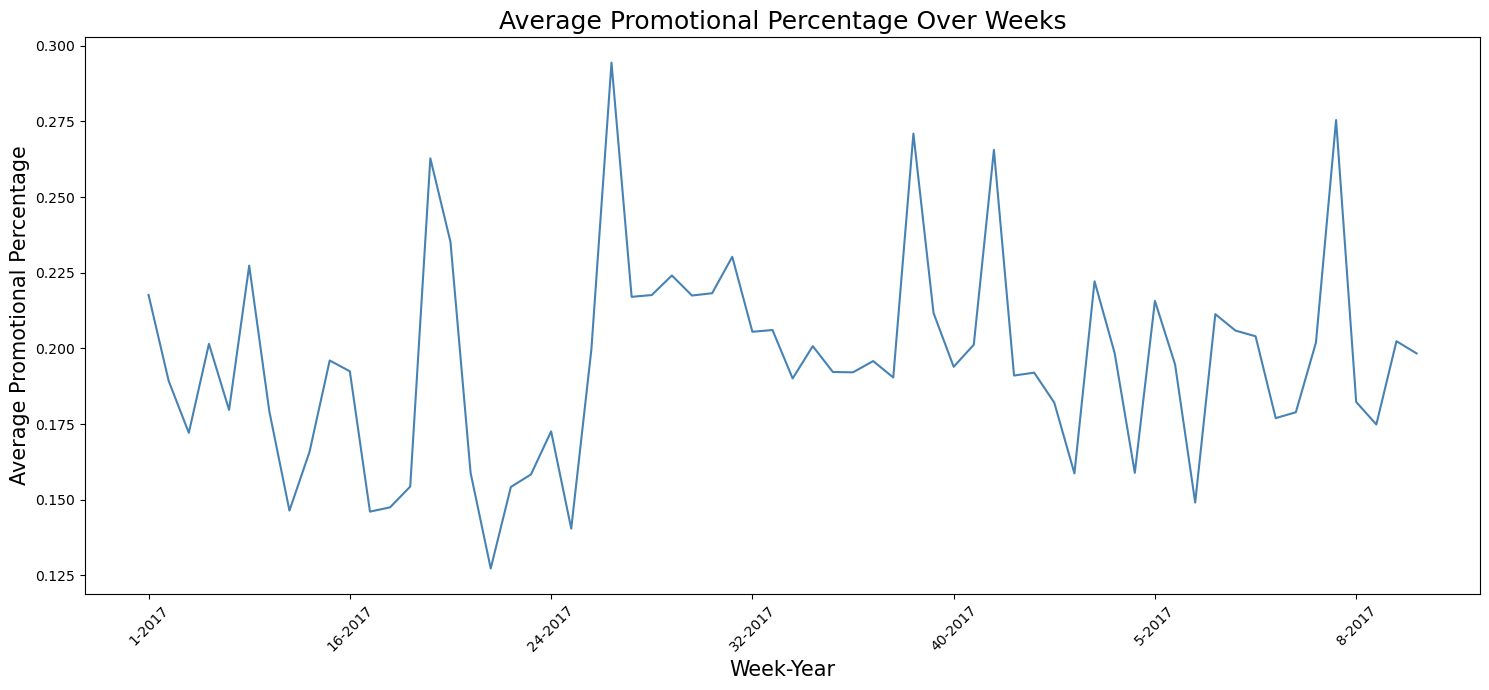

In [45]:
import matplotlib.pyplot as plt

# Creating 'week-year' for plotting
grouped['week-year'] = grouped['week'].astype(str) + '-' + grouped['year'].astype(str)

# Group by 'week-year' and calculate the mean of 'promo_perc'
weekly_promo = grouped.groupby('week-year')['promo_perc'].mean()

# Plot
plt.figure(figsize=(15, 7))
weekly_promo.plot(color='steelblue')
plt.title('Average Promotional Percentage Over Weeks', fontsize=18)
plt.xlabel('Week-Year', fontsize=15)
plt.ylabel('Average Promotional Percentage', fontsize=15)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [46]:
 grouped =(
     df1
     .loc[df1['state']=='Completed']
     .groupby([df1['created_date'].dt.isocalendar().week, df1['created_date'].dt.month, df1['created_date'].dt.quarter, df1['created_date'].dt.isocalendar().year])
     ['promo_perc']
     .mean()
 )
#grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
grouped.columns = ['week', 'month', 'quarter', 'promo_perc']
print(grouped)

week  created_date  created_date  year
1     1             1             2017   0.22
                                  2018   0.19
2     1             1             2017   0.26
                                  2018   0.24
3     1             1             2017   0.22
                                         ... 
49    12            4             2017   0.16
50    12            4             2017   0.15
51    12            4             2017   0.21
52    1             1             2016   0.21
      12            4             2017   0.20
Name: promo_perc, Length: 76, dtype: float64


Make the Line Plot

look for weeks/months/days where promotion in percentage/ price high. Which one to use?

## 4. Feature Analysis

- Scatterplot
- Heatmap Correlation
- Pairplot
- Groupby comparison

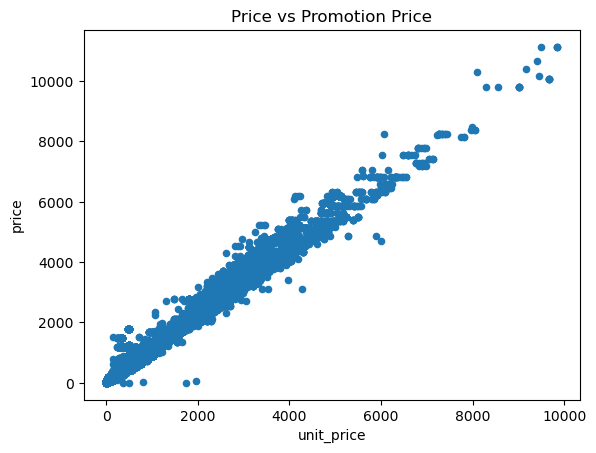

In [47]:
df1.plot(kind='scatter', x='unit_price', y='price', title='Price vs Promotion Price');

In [48]:
df1.head()

,order_id,created_date,total_paid,state,product_quantity,sku,unit_price,date,short,long,name,desc,price,in_stock,type,price_promotion,promo_price,unit_price_total,order_price,order_inc_promo,diff_paid_totalprice,promo_perc,year,week,day,month,quarter,created_month
0,343034,2017-04-04 10:47:28,23.99,Shopping Basket,1.00,8MO0008,23.99,2017-04-04 10:47:28,8MO,8Mobility,8Mobility iSlice Micro SD Adapter Macbook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,23.99,True,NaN,0.31,2017,14,2,4,2,4
1,343261,2017-04-04 18:43:37,23.99,Shopping Basket,1.00,8MO0008,23.99,2017-04-04 18:43:37,8MO,8Mobility,8Mobility iSlice Micro SD Adapter Macbook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,23.99,True,NaN,0.31,2017,14,2,4,2,4
2,344410,2017-04-08 18:41:41,30.98,Pending,1.00,8MO0008,23.99,2017-04-08 00:59:00,8MO,8Mobility,8Mobility iSlice Micro SD Adapter Macbook Pro ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,False,12585395,True,23.99,23.99,23.99,True,NaN,0.31,2017,14,6,4,2,4
3,345623,2017-04-12 11:06:14,38.97,Pending,1.00,8MO0009,23.99,2017-04-12 10:38:38,8MO,8Mobility,8Mobility iSlice Micro SD Adapter for Macbook ...,Micro SD card adapter for MacBook Pro Retina 1...,35.00,True,12585395,True,23.99,23.99,34.98,True,NaN,0.31,2017,15,3,4,2,4
4,345623,2017-04-12 11:06:14,38.97,Pending,1.00,ZAG0022,10.99,2017-04-12 10:59:55,ZAG,ZaggKeys,Zagg invisibleSHIELD Screen Protector Apple Wa...,Screen Protector for Apple Watch.,16.99,True,2425,True,10.99,10.99,34.98,True,NaN,0.35,2017,15,3,4,2,4


In [49]:
df1['unit_price'].max()

9841.99

In [50]:
print('This worked well. Congratulations')

This worked well. Congratulations
